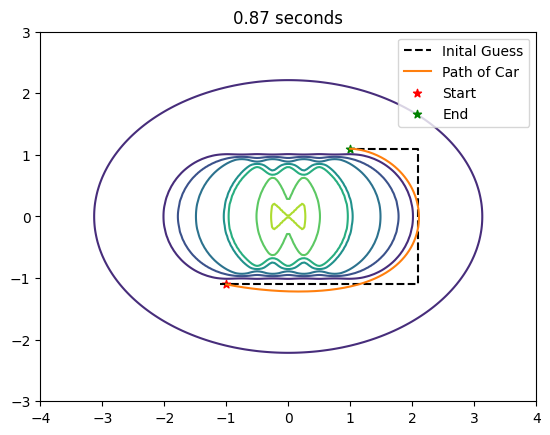

0.8714815798939145

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp

def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

def C(x, y, W1=1):
    '''
    Uses the obstacle function to combine all of our ellipses that we used to make our track
    '''
    return obstacle(x, y, 3*W1, r=(100,100)) - obstacle(x, y, W1,r=(10,5)) + obstacle(x, y, W1) + obstacle(x, y, W1, c=(1,0)) + obstacle(x, y, W1, c=(-1,0)) + obstacle(x, y, W1, c=(.5,0)) + obstacle(x, y, W1, c=(-.5,0))

def C_dx(x, y, W1=1):
    '''
    derivative with respect to x of the C function
    '''
    return obstacle_dx(x, y, 3*W1, r=(100,100)) - obstacle_dx(x, y, W1,r=(10,5)) + obstacle_dx(x, y, W1) + obstacle_dx(x, y, W1, c=(1,0)) + obstacle_dx(x, y, W1, c=(-1,0)) + obstacle_dx(x, y, W1, c=(.5,0)) + obstacle_dx(x, y, W1, c=(-.5,0))

def C_dy(x, y, W1=1):
    ''' 
    derivative with respect to y of the C function 
    '''
    return obstacle_dy(x, y, 3*W1, r=(100,100)) - obstacle_dy(x, y, W1,r=(10,5)) + obstacle_dy(x, y, W1) + obstacle_dy(x, y, W1, c=(1,0)) + obstacle_dy(x, y, W1, c=(-1,0)) + obstacle_dy(x, y, W1, c=(.5,0)) + obstacle_dy(x, y, W1, c=(-.5,0))

def K(delta, vx, vy, lmb = 20, cushion=.1, L = .05, M = 3.):
    '''Integral constraint due to centripetal acceleration'''
    return (cushion / (delta - np.arctan(L*M/(vx**2 + vy**2)))) ** lmb

def K_dvx(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vx'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vx*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_dvy(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vy'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vy*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_ddelta(delta, vx, vy, lmb=20, cushion=.1, L=.5, M=3.):
    ''' derivative of K with respect to delta '''
    return -lmb*(cushion / (delta - np.arctan(L*M/(vx**2 + vy**2))))**(lmb+1) / cushion

def plot_track():
    X,Y = np.meshgrid(np.linspace(-5,5,600),np.linspace(-5,5,600))
    Z = C(X,Y, W1=1)

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X,Y,Z,edgecolor=None,linewidth=0)
    ax.set_zlim(0,3)
    ax.view_init(elev=84,azim=90)
    ax.axis("off")
    ax.set_title("3D View")

    ax2 = fig.add_subplot(122)
    ax2.contour(X, Y, Z)
    ax2.set_xbound([-4,4])
    ax2.set_ybound([-3,3])
    ax2.set_title("2D Projection")

    ax2.axis('off')
    plt.show()

def naive_system():

    W1 = 100
    W2 = .02
    n = 200
    t = np.linspace(0, 1, n)

    C0 = C(1.25, 1.25, W1)

    def ode(t, s, p):
        return p[0] * np.array([
            s[2],
            s[3],
            1/(2*W2)*s[6],
            1/(2*W2)*s[7],
            C_dx(s[0], s[1], W1),
            C_dy(s[0], s[1], W1),
            -s[4],
            -s[5]
        ])
    
    def bc(ya, yb, p):
        return np.array([
            ya[0] + 1, ya[1] + 1.1, ya[2], ya[3], yb[0] - 1, yb[1] - 1.1, yb[2], yb[3],
            
            # H(tf) = 0
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]**2/(2*W2) + yb[7]**2/(2*W2) - (1 + C0 + (yb[6]**2+yb[7]**2/(4*W2)))
        ])
    
    guess = np.ones((8, n))

    path_x = np.concatenate((np.linspace(-1.1, 2.1, 100), 2.1*np.ones(75), np.linspace(1.1, 2.1, 25)[::-1]))
    path_y = np.concatenate((-1.1*np.ones(100), np.linspace(-1.1,1.1,75), 1.1*np.ones(25)))


    guess[0] = path_x
    guess[1] = path_y
    p0 = np.array([.5])

    sol = solve_bvp(ode, bc, t, guess, p0, max_nodes=30000)

    X = np.linspace(-4, 4, 200)
    Y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(X, Y)
    Z = C(X, Y)


    plt.plot(guess[0], guess[1], "--k", label="Inital Guess")
    plt.contour(X, Y, Z)
    plt.plot(sol.sol(t)[0], sol.sol(t)[1], "tab:orange", label="Path of Car")
    plt.scatter(-1, -1.1, marker="*", color="red", label="Start")
    plt.scatter(1, 1.1, marker="*", color="green", label="End")
    plt.xlim([-4,4])
    plt.ylim([-3,3])
    plt.legend()
    plt.title(f"{sol.p[0]:.2F} seconds")
    plt.show()

    return sol.p[0]

naive_system()

C:\Users\legit\AppData\Local\Temp\ipykernel_2852\4184661166.py:27: RuntimeWarning: invalid value encountered in divide
  -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:82: RuntimeWarning: divide by zero encountered in divide
  lm_v2 = L*M/(v2)
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:84: RuntimeWarning: invalid value encountered in multiply
  denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\4184661166.py:28: RuntimeWarning: invalid value encountered in divide
  -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:90: RuntimeWarning: divide by zero encountered in divide
  lm_v2 = L*M/(v2)
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:92: RuntimeWarning: invalid value encountered in multiply
  denomin

       message: The maximum number of mesh nodes is exceeded.
       success: False
        status: 1
             x: [ 0.000e+00  1.122e-03 ...  9.989e-01  1.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x000002680602C7C0>
             p: [ 1.585e+00]
             y: [[-1.006e+00 -1.006e+00 ...  1.010e+00  1.006e+00]
                 [-1.104e+00 -1.104e+00 ...  1.098e+00  1.104e+00]
                 ...
                 [-8.051e+02 -7.952e+02 ...  2.509e-02  2.495e-02]
                 [-3.540e+00 -3.528e+00 ...  2.496e-02  2.495e-02]]
            yp: [[ 3.955e-02  8.651e-02 ... -3.598e+00 -3.598e+00]
                 [ 3.955e-02  4.017e-02 ...  4.880e+00  4.880e+00]
                 ...
                 [ 9.128e+03  9.148e+03 ... -3.006e-02 -2.590e-04]
                 [ 5.408e+00  9.107e+00 ... -2.126e-02 -2.114e-02]]
 rms_residuals: [ 3.504e+00  3.129e+00 ...  3.223e-01  2.612e-01]
         niter: 3
[[-1.00623771e+00 -1.00210069e+00 -9.93711236e-01 ...  

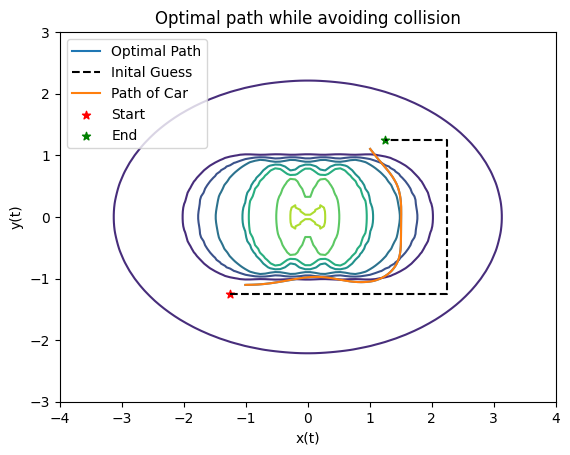

1.59 seconds
1 5 0.12 200


In [24]:
L = 0.12
M = 200
W1 = 1
W2 = 5
W3 = 1
W4 = 1
W5 = 1
def constraints_path():
    eps = 1e-5


    # ODE Function
    def ode(t,y,p):
        '''defines the ODE system''',
        u_acc =  1/(2*W1) * (y[8] * np.cos(y[4]) + y[9] * np.sin(y[4]))
        u_turn = (1/(2*W2)) * (y[11])
        v = np.sqrt(y[2]**2 + y[3]**2)
        # print(y[:,0])
        return p[0] * np.array([y[2],
                                y[3],
                                u_acc * np.cos(y[4]),
                                u_acc * np.sin(y[4]),
                                (v) * np.tan(y[5])/ L,
                                u_turn,
                                100 * C_dx(y[0], y[1]),
                                100 * C_dy(y[0], y[1]),
                                -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
                                -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),
                                y[8] * u_acc * np.sin(y[4]) - y[9] * u_acc * np.cos(y[4]),
                                (-y[10]/L) * v /((np.cos(y[5])/L)**2) + K_ddelta(y[5], y[2], y[3],L=L,M=M)])

    # Boundary Conditions
    def bc(ya, yb, p):
        ''' defines the boundary conditions'''
        u_acc =  1/(2*W1) * (yb[8] * np.cos(yb[4]) + yb[9] * np.sin(yb[4]))
        u_turn = (1/(2*W2)) * (yb[11])
        lagrangian = 1 + 100 * C(yb[0],yb[1]) + W1 * u_acc**2 + W2 * u_turn**2 + K(yb[5],yb[2],yb[3])
        hamiltonian_condition  = (yb[6:]).T@ np.array([yb[2],
                                yb[3],
                                u_acc * np.cos(yb[4]),
                                u_acc * np.sin(yb[4]),
                                (np.sqrt(yb[2]**2 + yb[3]**2)) * np.tan(yb[5])/ L,
                                (1/(2*W2)) * (yb[11])]) -  lagrangian

        return np.array([ya[0] + 1, ya[1] + 1.1, ya[2], ya[3], ya[4], ya[5], yb[0] -1, yb[1] - 1.1, yb[8], yb[9], yb[10], yb[11],hamiltonian_condition])

                    # Define domain and initial guesses
    t = np.linspace(0,1,100)
    y0 = np.ones((12, len(t)))
    path_x = np.concatenate((np.linspace(-1.25, 2.25, 50), 2.25*np.ones(38), np.linspace(1.25, 2.25, 12)[::-1]))
    path_y = np.concatenate((-1.25*np.ones(50), np.linspace(-1.25,1.25,38), 1.25*np.ones(12)))


    y0[0] = path_x
    y0[1] = path_y
    p0 = np.array([0.5])

    # Solve the bvp and print optimal time
    sol = solve_bvp(ode, bc,t,y0,p0)
    # print("Optimal time", -sol.p[0]*t[-1])
    # if -sol.p[0]*t[-1] > 0:
        
    # Create meshgrid to plot obstacle
    x = np.linspace(-4,4,100)
    y = np.linspace(-3,3,100)
    X, Y = np.meshgrid(x,y)
    print(sol)
    print(sol.sol(t))
    # Plot optimal path and obstacle
    plt.plot(sol.y[0],sol.y[1], label = 'Optimal Path')
    
    plt.plot(path_x,path_y, "--k", label="Inital Guess")
    plt.contour(X, Y, C(X,Y))
    print(sol.sol(t))
    plt.plot(sol.sol(t)[0], sol.sol(t)[1], "tab:orange", label="Path of Car")
    plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
    plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    plt.title('Optimal path while avoiding collision')
    plt.legend()
    # plt.xlim([-4,4])
    # plt.ylim([-3,3])
    plt.show()
    print(f"{sol.p[0]:.2F} seconds")
    print(W1,W2,L,M)
# plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
# plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
# plt.legend()
constraints_path()
# for i in np.arange(1,25,1):
#     for j in np.arange(1,25,1):
#         for k in np.arange(0.01,0.2,0.04):
                
#             W1 = i
#             W2 = j
#             L = k
                
#             # plt.xlim([-4,4])
#             # plt.ylim([-3,3])
#             constraints_path()

0.649


C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2983826921.py:28: RuntimeWarning: invalid value encountered in divide
  -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:82: RuntimeWarning: divide by zero encountered in divide
  lm_v2 = L*M/(v2)
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:84: RuntimeWarning: invalid value encountered in multiply
  denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2983826921.py:29: RuntimeWarning: invalid value encountered in divide
  -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:90: RuntimeWarning: divide by zero encountered in divide
  lm_v2 = L*M/(v2)
C:\Users\legit\AppData\Local\Temp\ipykernel_2852\2312573799.py:92: RuntimeWarning: invalid value encountered in multiply
  denomin

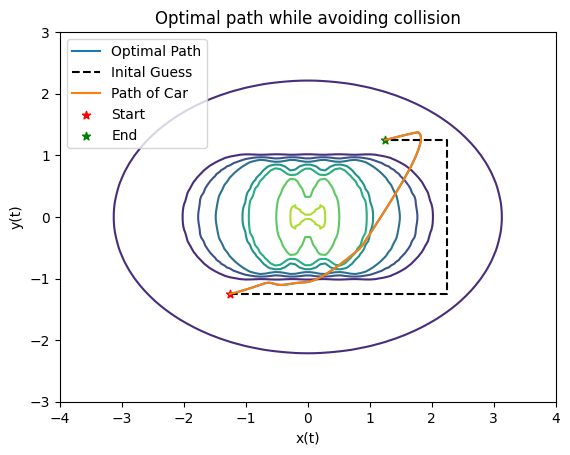

2.01 seconds
1 5 0.649 200


In [34]:
for L in [.649]:
    print(L)
    M = 200
    W1 = 1
    W2 = 5
    W3 = 1
    W4 = 1
    W5 = 1
    def constraints_path():
        eps = 1e-5


        # ODE Function
        def ode(t,y,p):
            '''defines the ODE system''',
            u_acc =  1/(2*W1) * (y[8] * np.cos(y[4]) + y[9] * np.sin(y[4]))
            u_turn = (1/(2*W2)) * (y[11])
            v = np.sqrt(y[2]**2 + y[3]**2)
            # print(y[:,0])
            return p[0] * np.array([y[2],
                                    y[3],
                                    u_acc * np.cos(y[4]),
                                    u_acc * np.sin(y[4]),
                                    (v) * np.tan(y[5])/ L,
                                    u_turn,
                                    100 * C_dx(y[0], y[1]),
                                    100 * C_dy(y[0], y[1]),
                                    -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
                                    -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),
                                    y[8] * u_acc * np.sin(y[4]) - y[9] * u_acc * np.cos(y[4]),
                                    (-y[10]/L) * v /((np.cos(y[5])/L)**2) + K_ddelta(y[5], y[2], y[3],L=L,M=M)])

        # Boundary Conditions
        def bc(ya, yb, p):
            ''' defines the boundary conditions'''
            u_acc =  1/(2*W1) * (yb[8] * np.cos(yb[4]) + yb[9] * np.sin(yb[4]))
            u_turn = (1/(2*W2)) * (yb[11])
            lagrangian = 1 + 100 * C(yb[0],yb[1]) + W1 * u_acc**2 + W2 * u_turn**2 + K(yb[5],yb[2],yb[3])
            hamiltonian_condition  = (yb[6:]).T@ np.array([yb[2],
                                    yb[3],
                                    u_acc * np.cos(yb[4]),
                                    u_acc * np.sin(yb[4]),
                                    (np.sqrt(yb[2]**2 + yb[3]**2)) * np.tan(yb[5])/ L,
                                    (1/(2*W2)) * (yb[11])]) -  lagrangian

            return np.array([ya[0] + 1.25, ya[1] + 1.25, ya[2], ya[3], ya[4], ya[5], yb[0] -1.25, yb[1] - 1.25, yb[8], yb[9], yb[10], yb[11],hamiltonian_condition])

                        # Define domain and initial guesses
        t = np.linspace(0,1,100)
        y0 = np.ones((12, len(t)))
        path_x = np.concatenate((np.linspace(-1.25, 2.25, 50), 2.25*np.ones(38), np.linspace(1.25, 2.25, 12)[::-1]))
        path_y = np.concatenate((-1.25*np.ones(50), np.linspace(-1.25,1.25,38), 1.25*np.ones(12)))


        y0[0] = path_x
        y0[1] = path_y
        p0 = np.array([0.5])

        # Solve the bvp and print optimal time
        sol = solve_bvp(ode, bc,t,y0,p0)
        # print("Optimal time", -sol.p[0]*t[-1])
        # if -sol.p[0]*t[-1] > 0:
            
        # Create meshgrid to plot obstacle
        x = np.linspace(-4,4,100)
        y = np.linspace(-3,3,100)
        X, Y = np.meshgrid(x,y)
        # Plot optimal path and obstacle
        plt.plot(sol.y[0],sol.y[1], label = 'Optimal Path')
        
        plt.plot(path_x,path_y, "--k", label="Inital Guess")
        plt.contour(X, Y, C(X,Y))
        plt.plot(sol.sol(t)[0], sol.sol(t)[1], "tab:orange", label="Path of Car")
        plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
        plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
        plt.xlabel('x(t)')
        plt.ylabel('y(t)')
        plt.title('Optimal path while avoiding collision')
        plt.legend()
        plt.xlim([-4,4])
        plt.ylim([-3,3])
        plt.show()
        print(f"{sol.p[0]:.2F} seconds")
        print(W1,W2,L,M)
    # plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
    # plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
    # plt.legend()
    constraints_path()
    # for i in np.arange(1,25,1):
    #     for j in np.arange(1,25,1):
    #         for k in np.arange(0.01,0.2,0.04):
                    
    #             W1 = i
    #             W2 = j
    #             L = k
                    
    #             # plt.xlim([-4,4])
    #             # plt.ylim([-3,3])
    #             constraints_path()